In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy import io
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-matrices-20/P8.mat
/kaggle/input/processed-matrices-20/P3.mat
/kaggle/input/processed-matrices-20/P20.mat
/kaggle/input/processed-matrices-20/P19.mat
/kaggle/input/processed-matrices-20/P7.mat
/kaggle/input/processed-matrices-20/P6.mat
/kaggle/input/processed-matrices-20/P2.mat
/kaggle/input/processed-matrices-20/P14.mat
/kaggle/input/processed-matrices-20/P4.mat
/kaggle/input/processed-matrices-20/P15.mat
/kaggle/input/processed-matrices-20/P10.mat
/kaggle/input/processed-matrices-20/P11.mat
/kaggle/input/processed-matrices-20/P17.mat
/kaggle/input/processed-matrices-20/P1.mat
/kaggle/input/processed-matrices-20/P9.mat
/kaggle/input/processed-matrices-20/P13.mat
/kaggle/input/processed-matrices-20/P12.mat
/kaggle/input/processed-matrices-20/P18.mat
/kaggle/input/processed-matrices-20/P16.mat
/kaggle/input/processed-matrices-20/P5.mat
/kaggle/input/stroke-fatigue-mi-eeg/P40.mat
/kaggle/input/stroke-fatigue-mi-eeg/P20.mat
/kaggle/input/stroke-fatigue-mi-eeg/P50.m

In [2]:
import numpy as np
from scipy import signal

# Assuming you have EEG data stored in a numpy array called 'eeg_data'
# with shape (number of trials, num channels, length of signal)

# Define the frequency bands of interest
def bandpower_per_channel(eeg_data):
#normal method...Im not going for the Welsh method
    frequency_bands = {
        'alpha': (8, 13),
        'delta': (0.5, 4),
        'theta': (4, 8),
        'beta': (13, 30)
    }

    # Calculate the power for each trial, channel, and frequency band
    num_trials, num_channels, signal_length = eeg_data.shape
    X = np.zeros((num_trials, 4*num_channels))

    for trial in range(num_trials):
        for channel in range(num_channels):
            for band_idx, (band, (f_low, f_high)) in enumerate(frequency_bands.items()):
                # Apply a bandpass filter to the segment
                b, a = signal.butter(4, [f_low / 250, f_high / 250], btype='band')
                filtered_segment = signal.filtfilt(b, a, eeg_data[trial, channel])

                # Calculate the power using the squared absolute values of the filtered segment
                power = np.mean(np.abs(filtered_segment) ** 2)

                # Store the power in the output matrix X
                X[trial, channel * len(frequency_bands) + band_idx] = power

                # Print the output matrix X
    print("Output shape:", X.shape)
    return X

In [3]:
#data is not normalized it has to be normalized in the range -1 to 1
def normalize(data):
    n_trials,n_channels,_=data.shape
    min_val=[]
    max_val=[]
    for i in range (0,n_channels):
        min_val.append(np.min(data[:,i,:]))
        max_val.append(np.max(data[:,i,:]))
    for i_chan in range (0,n_channels):
        for i_trial in range(0,n_trials):
            data[i_trial,i_chan,:] = (data[i_trial,i_chan,:] - min_val[i_chan]) * 2 / (max_val[i_chan] - min_val[i_chan]) - 1
    return data

#n_data = normalize(data)

In [4]:
def get_feature_matrix_per_run(X,trials_per_run=5):  
    k=trials_per_run
    #temp = np.zeros((1,9))
    temp = np.zeros((1,20))
    #x = np.zeros((1,9))
    x = np.zeros((1,20))
    for i in range(0,40,k):
        temp = np.mean(X[i:i+k,:],axis=0)
        print(temp)
        print(temp.shape)
        if i==0:
            #x = np.reshape(temp,(1,9))
            x = np.reshape(temp,(1,20))

        else:
            #x= np.concatenate((x,np.reshape(temp,(1,9))),axis=0)
            x = np.concatenate((x,np.reshape(temp,(1,20))),axis=0)
            
    return x

In [5]:
def preprocess(path):
    m = scipy.io.loadmat(path)
    data = m['data']
    #need shape: trials, channels, length
    data = np.swapaxes(data,1,2)
    data = np.swapaxes(data,0,1)
    

    def grand_average(data):
        # Define channel mappings for each region
        frontal_channels = [0, 1, 2, 3, 4, 5, 6]
        central_channels = [7, 8, 9, 12, 13, 14]
        temporal_channels = [10, 11, 15, 16, 19, 20, 24, 25]
        parietal_channels = [17, 18, 21, 22, 23]
        occipital_channels = [26, 27, 28]

        # Initialize the grand averaged data matrix
        grand_avg_data = np.zeros((data.shape[0], 5, data.shape[2]))

        # Perform grand averaging for each trial
        for i in range(data.shape[0]):
            # Extract region-specific channels and compute their mean
            frontal_avg = np.mean(data[i, frontal_channels, :], axis=0)
            central_avg = np.mean(data[i, central_channels, :], axis=0)
            temporal_avg = np.mean(data[i, temporal_channels, :], axis=0)
            parietal_avg = np.mean(data[i, parietal_channels, :], axis=0)
            occipital_avg = np.mean(data[i, occipital_channels, :], axis=0)

            # Assign the averaged channels to the grand averaged data matrix
            grand_avg_data[i, 0, :] = frontal_avg
            grand_avg_data[i, 1, :] = central_avg
            grand_avg_data[i, 2, :] = temporal_avg
            grand_avg_data[i, 3, :] = parietal_avg
            grand_avg_data[i, 4, :] = occipital_avg

        return grand_avg_data
    data = grand_average(data)

    n_data = normalize(data)
    return n_data

In [35]:
data = preprocess("/kaggle/input/stroke-fatigue-mi-eeg/P50.mat")

*This is only a trial for generating the topopolots...might h=give it a try or else will try MATLAB*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.channels import Montage

# The data you provided
data = {
    'name': ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4', 'FT7', 'FT8', 'Cz', 'C3', 'C4', 'T3', 'T4',
             'CP3', 'CP4', 'TP7', 'TP8', 'Pz', 'P3', 'P4', 'T5', 'T6', 'Oz', 'O1', 'O2', 'HEOL', 'VEOR'],
    'X': [0.95, 0.95, 0.719, 0.673, 0.673, 0.587, 0.587, 0.391, 0.36, 0.36, 0.309, 0.309, 3.75e-33, 4.4e-17, 4.4e-17,
          6.12e-17, 6.12e-17, -0.36, -0.36, -0.309, -0.309, -0.719, -0.673, -0.673, -0.587, -0.587, -0.999, -0.95,
          -0.95, 0.652, 0.727],
    'Y': [0.309, -0.309, 0, 0.545, -0.545, 0.809, -0.809, 0, 0.676, -0.676, 0.95, -0.95, -6.12e-17, 0.719, -0.719,
          0.999, -0.999, 0.676, -0.676, 0.95, -0.95, -8.81e-17, 0.545, -0.545, 0.809, -0.809, -1.22e-16, 0.309, -0.309,
          0.608, -0.309],
    'Z': [-0.0349, -0.0349, 0.695, 0.5, 0.5, -0.0349, -0.0349, 0.921, 0.643, 0.643, -0.0349, -0.0349, 1, 0.695, 0.695,
          -0.0349, -0.0349, 0.643, 0.643, -0.0349, -0.0349, 0.695, 0.5, 0.5, -0.0349, -0.0349, -0.0349, -0.0349, -0.0349,
          -0.454, -0.613]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Electrodes indices for different regions
frontal_indices = [0, 1, 2, 3, 4, 5, 6]
central_indices = [7, 8, 9, 12, 13, 14]
temporal_indices = [10, 11, 15, 16, 19, 20, 24, 25]
parietal_indices = [17, 18, 21, 22, 23]
occipital_indices = [26, 27, 28]

# Create a custom montage for plotting the topoplots
montage_pos = {
    df.iloc[i]['name']: [df.iloc[i]['X'], df.iloc[i]['Y'], df.iloc[i]['Z']]
    for i in range(len(df))
}
montage = Montage(montage_pos, 'custom', df['name'].tolist())

# Reshape the data matrix X to match the number of electrodes in the montage
n_trials = X.shape[0]
X = X.reshape(n_trials, len(montage.ch_names), -1)

# Create the MNE Info object
info = mne.create_info(montage.ch_names, 1000.0, 'eeg')

# Loop through the first and last trials
for trial_idx in [0, n_trials - 1]:
    # Create an MNE Raw object for each trial
    raw_data = X[trial_idx]
    raw = mne.io.RawArray(raw_data.T, info)

    # Set the montage for plotting
    raw.set_montage(montage)

    # Plot the topoplot for each band (alpha, delta, theta, beta)
    bands = ['Alpha', 'Delta', 'Theta', 'Beta']
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'Topoplots for Trial {trial_idx + 1}', fontsize=16)
    axes = axes.ravel()

    for band_idx, band_label in enumerate(bands):
        mne.viz.plot_topomap(raw.average(band_idx * len(montage.ch_names), (band_idx + 1) * len(montage.ch_names)),
                             axes=axes[band_idx], show=False)
        axes[band_idx].set_title(f'{band_label} Band')

    plt.tight_layout()
    plt.show()

In [7]:
X = bandpower_per_channel(data)

Output shape: (40, 20)


#### def generate_power_plots(X,x):
 
    lines = [X[:,0],X[:,4],X[:,8],X[:,12],X[:,16]]
    labels  = ['Frontal','Central','Temporal','Parietal','Occipital']

    for i,l in zip(lines,labels):  
        plt.plot(i,label='l')
        plt.legend(labels)     
    plt.show()

    
    lines = [X[:,1],X[:,5],X[:,9],X[:,13],X[:,17]]
    labels  = ['Frontal','Central','Temporal','Parietal','Occipital']
    for i,l in zip(lines,labels):  
        plt.plot(i,label='l')
        plt.legend(labels)     
    plt.show()
    
    
    lines = [X[:,2],X[:,6],X[:,10],X[:,14],X[:,18]]
    labels  = ['Frontal','Central','Temporal','Parietal','Occipital']
    for i,l in zip(lines,labels):  
        plt.plot(i,label='l')
        plt.legend(labels)     
    plt.show()
    
    
    lines = [X[:,3],X[:,7],X[:,11],X[:,15],X[:,19]]
    labels  = ['Frontal','Central','Temporal','Parietal','Occipital']
    for i,l in zip(lines,labels):  
        plt.plot(i,label='l')
        plt.legend(labels)     
    plt.show()
    


In [8]:
def generate_power_plots(X):
    labels = ['Frontal', 'Central', 'Temporal', 'Parietal', 'Occipital']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]
    markers = ['o', 's', '^', 'D', 'v']
    band_labels = ['Alpha', 'Delta', 'Theta', 'Beta']
    
    for band_idx, band_label in enumerate(band_labels):
        fig, ax = plt.subplots(figsize=(8, 6))
        
        for channel_idx, label in enumerate(labels):
            channel_data = X[:, band_idx + (channel_idx * 4)]
            ax.plot(channel_data, label=label, color=colors[channel_idx], linestyle=linestyles[channel_idx], marker=markers[channel_idx])
        
        ax.set_xlabel('Trials')
        ax.set_ylabel('Power')
        ax.set_title(f'{band_label} Powers')
        
        # Position the legend outside the plot area
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels))
        
        plt.tight_layout()
        plt.show()

# Usage example:
# Assuming you have the matrix 'X' of shape (trials, 4*5)
generate_power_plots(X)

NameError: name 'X' is not defined

[3.17934090e-05 3.70495011e-04 5.02146641e-05 7.48113520e-05
 2.93955702e-05 5.18416059e-04 3.37174707e-05 5.90620703e-05
 2.77198037e-05 3.40528796e-04 4.57637219e-05 5.21129083e-05
 1.34033242e-05 2.24940218e-04 1.99206640e-05 1.96514584e-05
 3.90940228e-05 5.78144932e-04 8.87472451e-05 5.61874159e-05]
(20,)
[5.71468611e-05 1.63511581e-03 1.04061694e-04 8.23278025e-05
 6.90293098e-05 2.19417949e-03 9.72595198e-05 7.38560802e-05
 2.51651469e-05 1.81820815e-03 4.85184458e-05 6.55615134e-05
 2.23096972e-05 1.47397275e-03 4.86587010e-05 3.61538545e-05
 4.55143224e-05 1.68692228e-03 7.20491115e-05 9.19127343e-05]
(20,)
[5.90349528e-05 4.00948904e-03 1.28572892e-04 1.14975952e-04
 5.04993690e-05 2.90637869e-03 7.79012216e-05 8.21910114e-05
 3.61398298e-05 6.41241303e-03 6.50465653e-05 1.19450211e-04
 2.02498191e-05 3.74338706e-03 3.19353980e-05 4.70194548e-05
 5.60165929e-05 7.70911857e-03 7.42481899e-05 1.15440499e-04]
(20,)
[6.13637635e-05 7.90262750e-03 8.20107465e-05 1.08609597e-04
 3.

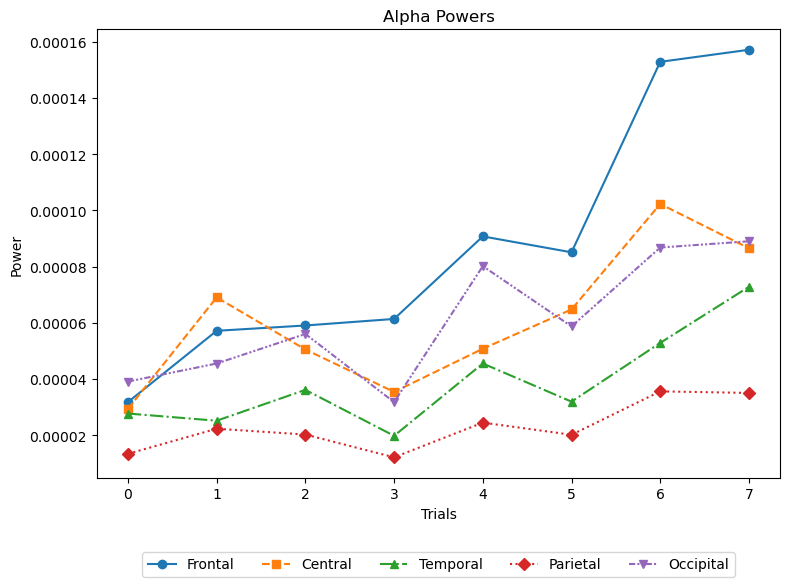

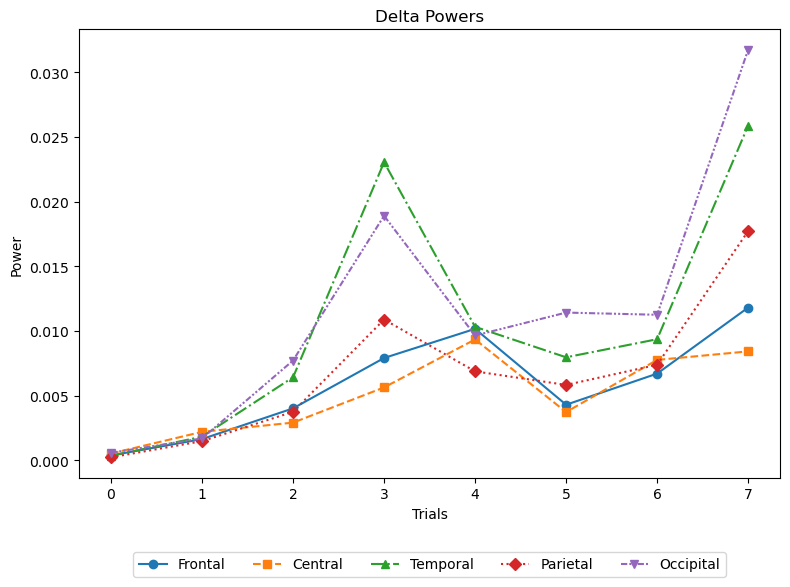

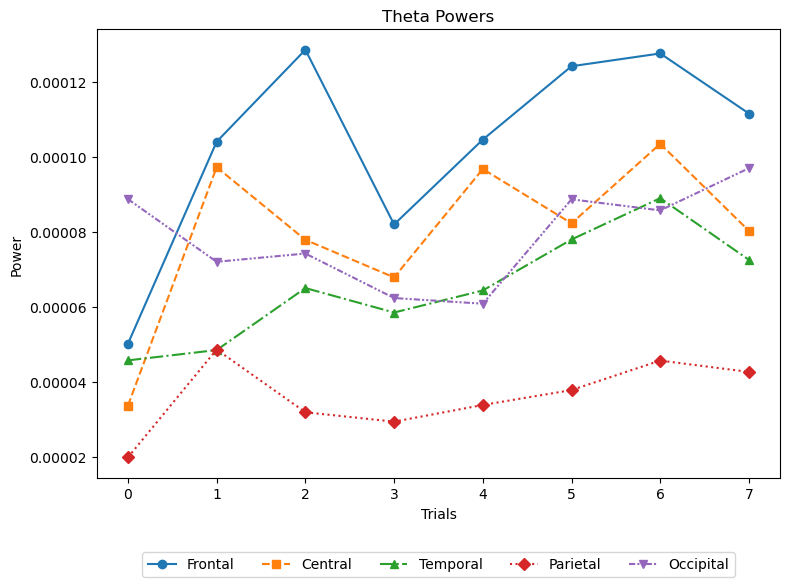

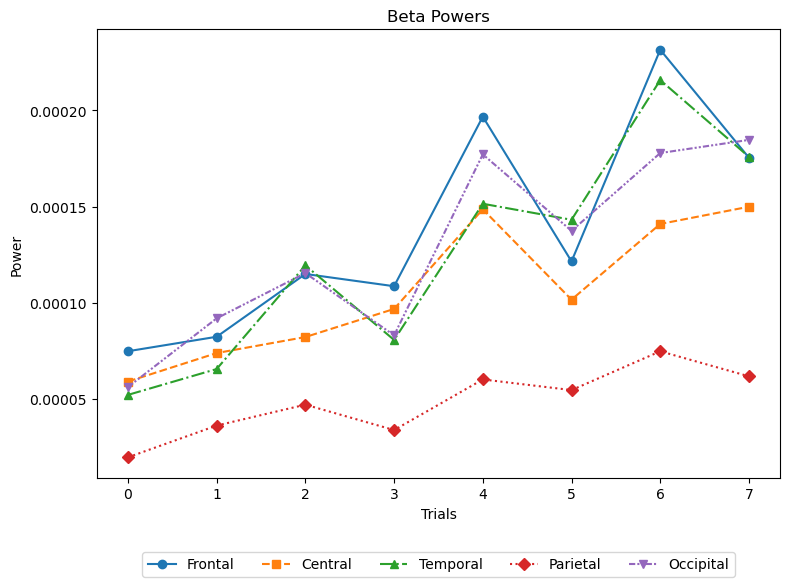

In [9]:
x = get_feature_matrix_per_run(X)
generate_power_plots(x)

In [6]:
def select_trials(X,k=5):
    # Calculate the average band powers across all channels
    average_powers = np.mean(X, axis=1)

    # Find the indices of trials with the highest and lowest average powers
    highest_indices = np.argsort(average_powers)[-k:]
    lowest_indices = np.argsort(average_powers)[:k]

    # Create the matrix x_train and populate it with the selected trials
    x_train = np.zeros((2*k, X.shape[1]))
    x_train[:k, :] = X[highest_indices, :]
    x_train[k:2*k, :] = X[lowest_indices, :]

    # Print the trial numbers for verification
    print("Trials with highest average powers:", highest_indices)
    print("Trials with lowest average powers:", lowest_indices)
    y = np.zeros((2*k,1))
    y[0:k,:]=1
    y[k:2*k,:]=-1
    print(y.shape)

    return x_train,y

# Usage example:
# Assuming you have the matrix 'X' of shape (trials, 20)
#x_train,y = select_trials(X,5)


In [7]:
def get_f_nf_matrices(data,labels):

    # Assuming X is your EEG data matrix, labels is your binary labels vector, and num_channels is the number of EEG channels.

    # First, create masks for left and right hand trials
    left_hand_mask = np.arange(data.shape[0]) % 2 == 0  # Even trials are left-hand trials
    right_hand_mask = np.arange(data.shape[0]) % 2 == 1  # Odd trials are right-hand trials

    # Create masks for fatigued and non-fatigued trials
    fatigued_mask = labels == 1
    nonfatigued_mask = labels == 0

    # Use the masks to extract the desired data subsets
    X_rh_f = data[right_hand_mask & fatigued_mask]
    X_rh_nf = data[right_hand_mask & nonfatigued_mask]
    X_lh_f = data[left_hand_mask & fatigued_mask]
    X_lh_nf = data[left_hand_mask & nonfatigued_mask]
    
    return X_rh_f,X_rh_nf,X_lh_f,X_lh_nf

    # Now, you have your separated data matrices as required


In [11]:
x_train.shape

(10, 20)

In [8]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

def plsr_optimization(X, y, num_components):
    # Initialize lists to store the evaluation scores
    mse_scores = []
    r2_scores = []

    # Iterate over the number of components
    for n in range(1, num_components+1):
        # Perform PLSR
        plsr = PLSRegression(n_components=n)
        plsr.fit(X, y)

        # Calculate the predictions
        y_pred = plsr.predict(X)

        # Calculate the mean squared error (MSE)
        mse = mean_squared_error(y, y_pred)
        mse_scores.append(mse)

        # Calculate the coefficient of determination (R^2)
        r2 = r2_score(y, y_pred)
        r2_scores.append(r2)

    # Find the index of the best number of components based on MSE
    best_mse_index = np.argmin(mse_scores)

    # Find the index of the best number of components based on R^2
    best_r2_index = np.argmax(r2_scores)

    # Get the best number of components based on MSE and R^2
    best_mse_components = best_mse_index + 1
    best_r2_components = best_r2_index + 1

    # Print the results for the best number of components based on MSE
    print("Best number of components based on MSE:", best_mse_components)
    print("MSE:", mse_scores[best_mse_index])

    # Print the results for the best number of components based on R^2
    print("Best number of components based on R^2:", best_r2_components)
    print("R^2:", r2_scores[best_r2_index])
    """
    # Plot the MSE scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_components + 1), mse_scores, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('PLSR Optimization based on MSE')
    plt.grid(True)
    plt.show()

    # Plot the R^2 scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_components + 1), r2_scores, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Coefficient of Determination (R^2)')
    plt.title('PLSR Optimization based on R^2')
    plt.grid(True)
    plt.show()
    """

    # Create the final PLSR model with the best number of components based on MSE
    best_plsr = PLSRegression(n_components=best_mse_components)
    best_plsr.fit(X, y)

    # Return the best model
    return best_plsr

# Usage example:
# Assuming you have the matrix 'x_train' of shape (10, 20) and vector 'y' of shape (10, 1)
#best_model = plsr_optimization(scaler.fit_transform(x_train), y, num_components=20)

In [31]:
y_pred = best_model.predict(scaler.fit_transform(X))
k=5
j=0
x_=np.empty((len(y_pred)//k,1))
for i in range(0,40,k):
    x_[j,0]=np.mean(y_pred[i:i+k,:],axis=0)
    j=j+1

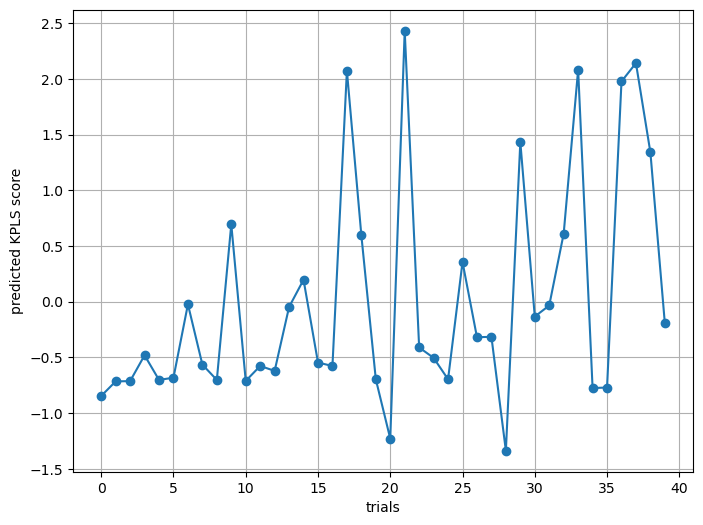

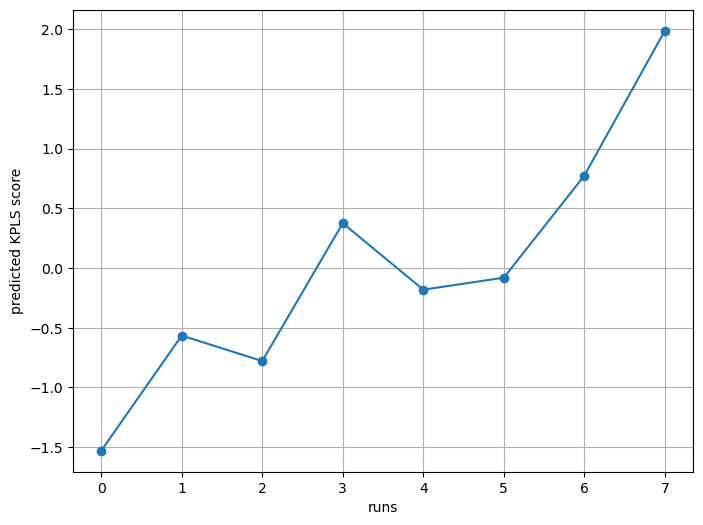

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(scaler.fit_transform(y_pred), marker='o')
plt.xlabel('trials')
plt.ylabel('predicted KPLS score')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(scaler.fit_transform(x_), marker='o')
plt.xlabel('runs')
plt.ylabel('predicted KPLS score')
plt.grid(True)
plt.show()

In [9]:
from sklearn.cluster import KMeans
def get_clusters(y_pred):
    num_classes=2
    kmeans = KMeans(n_clusters=num_classes)
    y_pred_clusters = kmeans.fit_predict(scaler.fit_transform(y_pred))
    labels = np.where(y_pred_clusters == np.argmax(np.bincount(y_pred_clusters)), 0, 1)
    return labels

    #labels = kmeans.labels_
    #print(labels)

In [10]:
path="/kaggle/input/processed-matrices-20"
save_path = "/kaggle/working"
for file in os.listdir(path):
    
    name=file.split('.')[0];
    

    data = preprocess(os.path.join(path,file))
    #print(data.shape)
    
    # data shape: trial,chan,length
    
    X = bandpower_per_channel(data)
    x_train,y = select_trials(X,5)
    best_model = plsr_optimization(scaler.fit_transform(x_train), y, num_components=20)
    y_pred = best_model.predict(scaler.fit_transform(X))
    labels=get_clusters(y_pred)
    X_rh_f,X_rh_nf,X_lh_f,X_lh_nf=get_f_nf_matrices(data,labels)
    #print(X_rh_f.shape)
    #break
    #os.makedirs(os.path.join(save_path,name), exist_ok=True)
    
    np.save(os.path.join(save_path,name+"_"+"X_rh_f"),X_rh_f)
    np.save(os.path.join(save_path,name+"_"+"X_rh_nf"),X_rh_nf)
    np.save(os.path.join(save_path,name+"_"+"X_lh_f"),X_lh_f)
    np.save(os.path.join(save_path,name+"_"+"X_lh_nf"),X_lh_nf)
    
    
    
    #all matrices are of shape: trials,chan,length




Output shape: (40, 20)
Trials with highest average powers: [17 24  2  1 10]
Trials with lowest average powers: [37 19 20 13 30]
(10, 1)
Best number of components based on MSE: 9
MSE: 2.8226429264939327e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [20 34 36 26 32]
Trials with lowest average powers: [18  8 23 30 25]
(10, 1)
Best number of components based on MSE: 12
MSE: 5.337137061885908e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [31 38 33 37 39]
Trials with lowest average powers: [16  4  2  8 20]
(10, 1)
Best number of components based on MSE: 10
MSE: 1.1537090738857297e-30
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [14 35 34 38 21]
Trials with lowest average powers: [ 4  9 11 30  5]
(10, 1)
Best number of components based on MSE: 9
MSE: 5.534352288191161e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [24  4  3 12 14]
Trials with lowest average powers: [ 0 17  1 34 19]
(10, 1)
Best number of components based on MSE: 12
MSE: 1.7379591818150416e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [ 8 39 23  0 17]
Trials with lowest average powers: [25 11 31 27 24]
(10, 1)
Best number of components based on MSE: 10
MSE: 1.1093356479670479e-32
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [29 34 17 37 33]
Trials with lowest average powers: [ 2 28 11 13 15]
(10, 1)
Best number of components based on MSE: 9
MSE: 4.683861624749758e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [27 32  1 21 19]
Trials with lowest average powers: [23 13 15 28  8]
(10, 1)
Best number of components based on MSE: 12
MSE: 1.7749370367472766e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [35  7 31 32 37]
Trials with lowest average powers: [15 12 24 27 18]
(10, 1)
Best number of components based on MSE: 10
MSE: 6.372516999988486e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [14 15 28 29 13]
Trials with lowest average powers: [24  2  0  3 21]
(10, 1)
Best number of components based on MSE: 9
MSE: 1.5284180038657104e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [32 24 37 35  6]
Trials with lowest average powers: [11 34 22 16  5]
(10, 1)
Best number of components based on MSE: 9
MSE: 3.2787031373248305e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [14 15 28 29 13]
Trials with lowest average powers: [24  2  0  3 21]
(10, 1)
Best number of components based on MSE: 9
MSE: 1.9351744081202945e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [16 39 20 27 12]
Trials with lowest average powers: [ 2  4 23  3  5]
(10, 1)
Best number of components based on MSE: 10
MSE: 6.224605580259546e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [29 34 25  0 35]
Trials with lowest average powers: [30  1 11 36 13]
(10, 1)
Best number of components based on MSE: 9
MSE: 1.1931521191467803e-30
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [32 33 29 28 16]
Trials with lowest average powers: [13  4 27 12  9]
(10, 1)
Best number of components based on MSE: 9
MSE: 8.997944700177166e-32
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [34 26 19 29  2]
Trials with lowest average powers: [15 22 18 33 38]
(10, 1)
Best number of components based on MSE: 9
MSE: 1.342296134040128e-30
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [ 0 32 35 36 24]
Trials with lowest average powers: [18 23 19 17  9]
(10, 1)
Best number of components based on MSE: 9
MSE: 1.4150192487401899e-30
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [ 2 20 14  1  0]
Trials with lowest average powers: [31 27 36 23 32]
(10, 1)
Best number of components based on MSE: 9
MSE: 4.646883769817523e-31
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [ 2 38 12 27  5]
Trials with lowest average powers: [ 6 24 29 35 20]
(10, 1)
Best number of components based on MSE: 12
MSE: 1.40873301340171e-29
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

Output shape: (40, 20)
Trials with highest average powers: [ 9 39 32 31  7]
Trials with lowest average powers: [27  2 12 15  1]
(10, 1)
Best number of components based on MSE: 12
MSE: 2.683359672915848e-30
Best number of components based on R^2: 9
R^2: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:300: UserWarning: Y residual is constant at iteration 9
  warnings.warn(f"Y residual is constant at iteration {k}")
/opt/conda/lib/python3.10/site-packages/

In [11]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/P4_X_rh_f.npy (deflated 5%)
  adding: kaggle/working/P2_X_rh_f.npy (deflated 5%)
  adding: kaggle/working/P20_X_lh_f.npy (deflated 5%)
  adding: kaggle/working/P3_X_lh_nf.npy (deflated 5%)
  adding: kaggle/working/P20_X_lh_nf.npy (deflated 6%)
  adding: kaggle/working/P16_X_lh_f.npy (deflated 6%)
  adding: kaggle/working/P15_X_rh_nf.npy (deflated 6%)
  adding: kaggle/working/P4_X_lh_f.npy (deflated 5%)
  adding: kaggle/working/P7_X_lh_f.npy (deflated 5%)
  adding: kaggle/working/P11_X_rh_nf.npy (deflated 6%)
  adding: kaggle/working/P15_X_lh_nf.npy (deflated 6%)
  adding: kaggle/working/P3_X_rh_f.npy (deflated 5%)
  adding: kaggle/working/P18_X_rh_f.npy (deflated 5%)
  adding: kaggle/working/P6_X_lh_nf.npy (deflated 6%)
  adding: kaggle/working/P8_X_lh_f.npy (deflated 5%)
  adding: kaggle/working/P1_X_lh_f.npy (deflated 6%)
  adding: kaggle/working/P12_X_rh_f.npy (deflated 5%)
  adding: kaggle/working/P16_X_lh_nf.npy (defla

In [12]:
!ls

P10_X_lh_f.npy	 P15_X_lh_nf.npy  P1_X_rh_f.npy    P5_X_rh_nf.npy
P10_X_lh_nf.npy  P15_X_rh_f.npy   P1_X_rh_nf.npy   P6_X_lh_f.npy
P10_X_rh_f.npy	 P15_X_rh_nf.npy  P20_X_lh_f.npy   P6_X_lh_nf.npy
P10_X_rh_nf.npy  P16_X_lh_f.npy   P20_X_lh_nf.npy  P6_X_rh_f.npy
P11_X_lh_f.npy	 P16_X_lh_nf.npy  P20_X_rh_f.npy   P6_X_rh_nf.npy
P11_X_lh_nf.npy  P16_X_rh_f.npy   P20_X_rh_nf.npy  P7_X_lh_f.npy
P11_X_rh_f.npy	 P16_X_rh_nf.npy  P2_X_lh_f.npy    P7_X_lh_nf.npy
P11_X_rh_nf.npy  P17_X_lh_f.npy   P2_X_lh_nf.npy   P7_X_rh_f.npy
P12_X_lh_f.npy	 P17_X_lh_nf.npy  P2_X_rh_f.npy    P7_X_rh_nf.npy
P12_X_lh_nf.npy  P17_X_rh_f.npy   P2_X_rh_nf.npy   P8_X_lh_f.npy
P12_X_rh_f.npy	 P17_X_rh_nf.npy  P3_X_lh_f.npy    P8_X_lh_nf.npy
P12_X_rh_nf.npy  P18_X_lh_f.npy   P3_X_lh_nf.npy   P8_X_rh_f.npy
P13_X_lh_f.npy	 P18_X_lh_nf.npy  P3_X_rh_f.npy    P8_X_rh_nf.npy
P13_X_lh_nf.npy  P18_X_rh_f.npy   P3_X_rh_nf.npy   P9_X_lh_f.npy
P13_X_rh_f.npy	 P18_X_rh_nf.npy  P4_X_lh_f.npy    P9_X_lh_nf.npy
P13_X_rh_nf.npy  P19_X_lh

In [13]:
from IPython.display import FileLink
FileLink(r'file.zip')


/kaggle/working/file.zip